In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import squidpy as sq
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# from muon import prot as pt
# from muon import MuData
# import muon as mu
import numpy as np
from jax.config import config

config.update("jax_enable_x64", True)
# config.update("jax_platform_name", "cpu")
# JAX_PLATFORM_NAME = "cpu"
%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_data = Path("/lustre/groups/ml01/workspace/moscot_paper/mapping")

In [2]:
scaler = MinMaxScaler()
adata_sc = sc.read(path_data / "adata_sc_processed.h5ad")
adata_p = sc.read(path_data / "adata_cite_processed.h5ad")
sc.pp.pca(adata_p, n_comps=30)
adata_sc.obsm["X_pca_protein"] = adata_p.obsm["X_pca"].copy()
adata_sc.obsm["X_pca_protein_scaled"] = scaler.fit_transform(
    adata_p.obsm["X_pca"].copy()
)
# sc.pp.subsample(adata_sc, fraction=0.5)

In [3]:
adata_spatial = sc.read(path_data / "vizgen_liver/adata_result.h5ad")
sc.pp.pca(adata_spatial, n_comps=30)
adata_spatial.obsm["spatial_scaled"] = scaler.fit_transform(
    adata_spatial.obsm["spatial"]
)
adata_spatial.obsm["X_pca_scaled"] = scaler.fit_transform(adata_spatial.obsm["X_pca"])
adata_spatial.obsm["X_pca_spatial_scaled"] = np.concatenate(
    [adata_spatial.obsm["X_pca_scaled"], adata_spatial.obsm["spatial_scaled"]], axis=1
)

In [4]:
print(
    np.var(adata_spatial.obsm["X_pca_scaled"]),
    np.var(adata_spatial.obsm["spatial_scaled"]),
    np.var(adata_spatial.obsm["X_pca_spatial_scaled"]),
    np.var(adata_sc.obsm["X_pca_protein_scaled"]),
)

0.011589507 0.06284179432600419 0.015285336883039543 0.012960515


In [5]:
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)

['default', 'despine']


/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


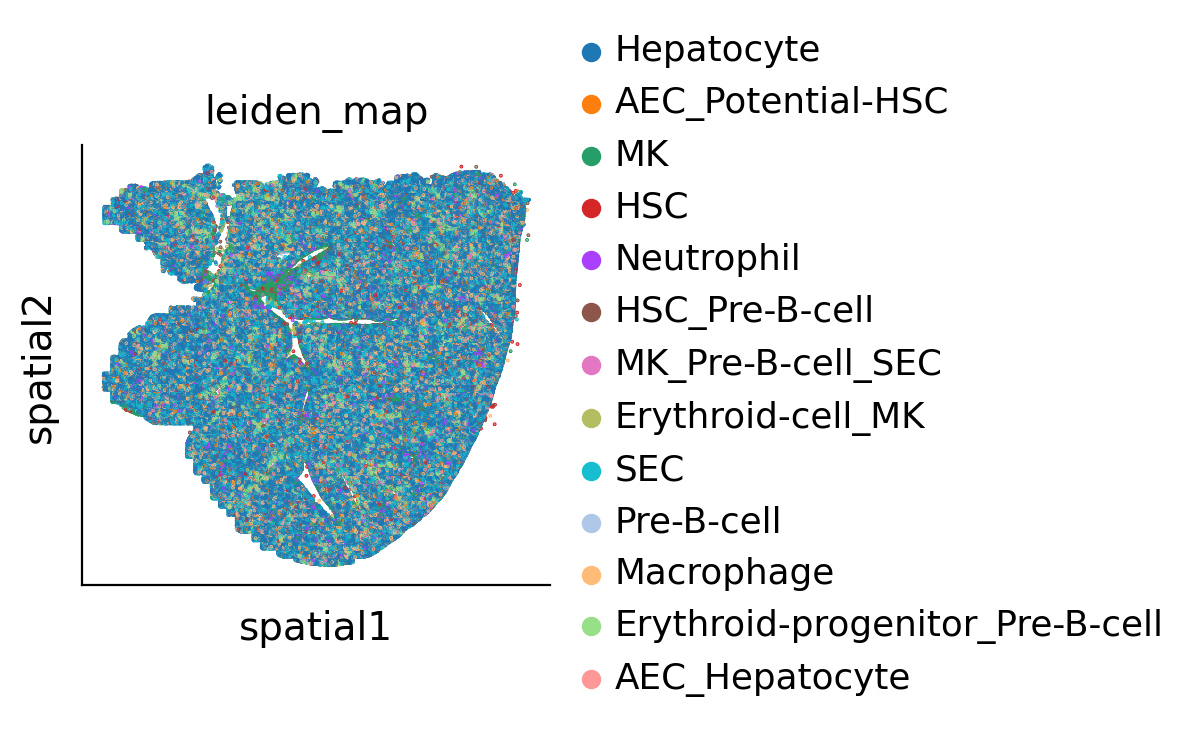

In [6]:
sc.set_figure_params(figsize=(3, 3), dpi=100)
sq.pl.spatial_scatter(adata_spatial, shape=None, color="leiden_map")

In [11]:
adata_spatial.var_names = [v.capitalize() for v in adata_spatial.var_names.values]

In [12]:
var_names = list(
    set(adata_sc.var_names.values).intersection(adata_spatial.var_names.values)
)
len(var_names)

336

In [13]:
import matplotlib.pyplot as plt

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


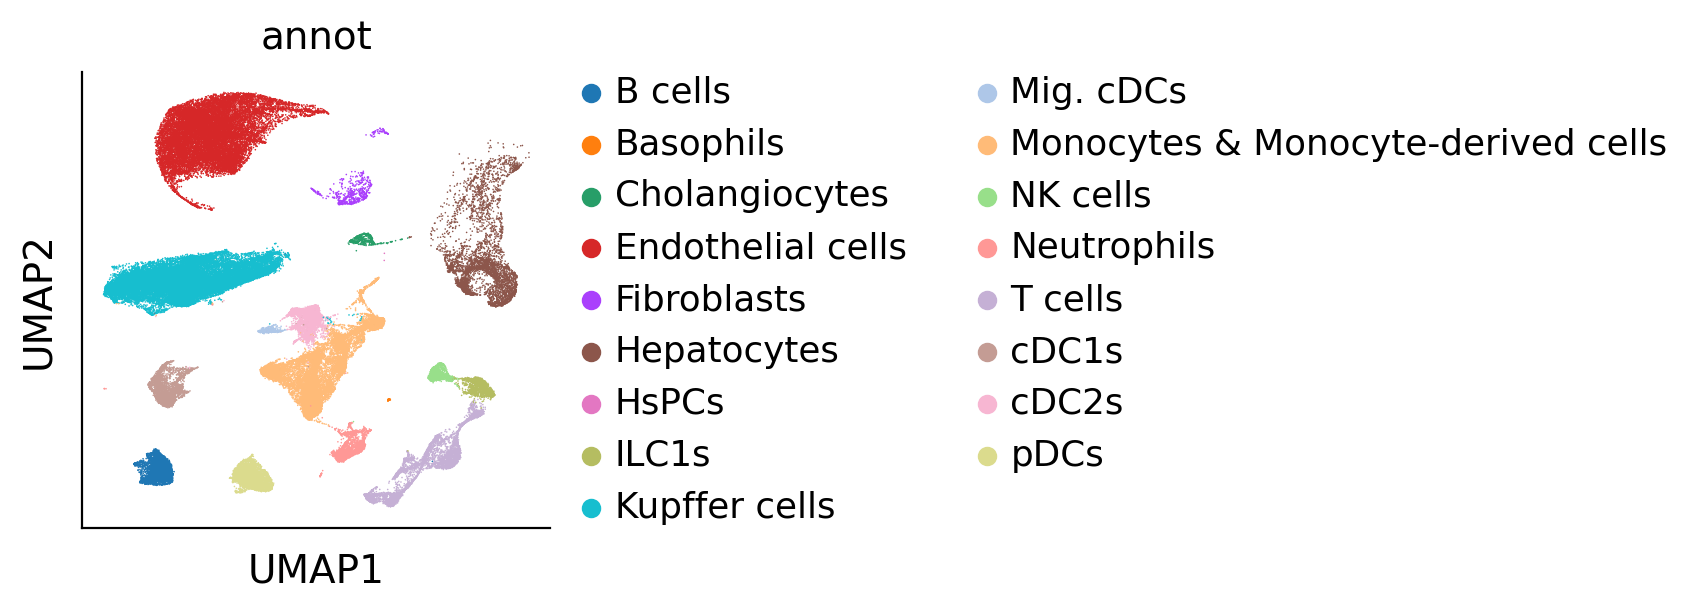

<Figure size 300x300 with 0 Axes>

In [14]:
sc.pl.umap(
    adata_sc,
    color=[
        # "n_counts",
        "annot",
    ],
)
plt.tight_layout()

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


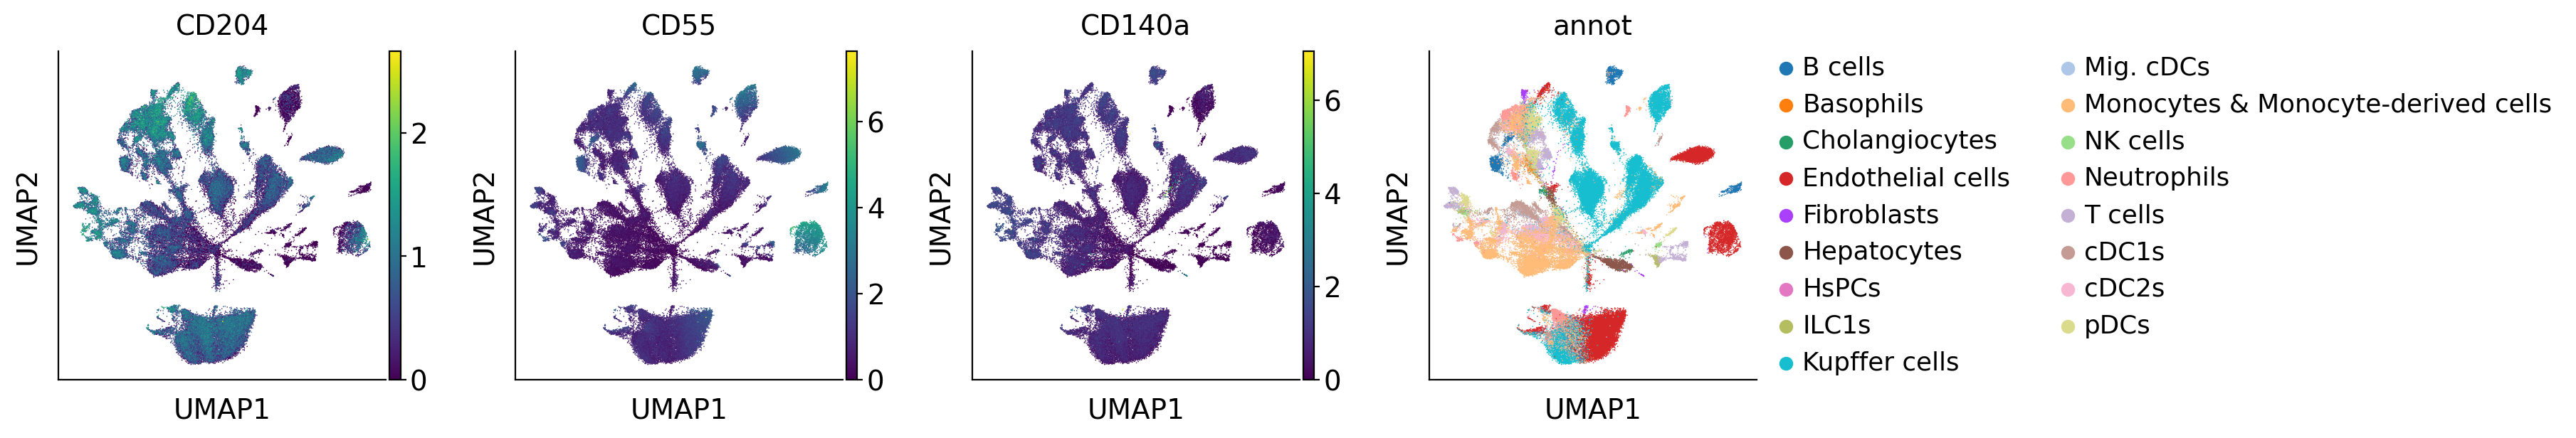

<Figure size 300x300 with 0 Axes>

In [15]:
sc.pl.umap(
    adata_p,
    color=["CD204", "CD55", "CD140a", "annot"],
)
plt.tight_layout()

In [16]:
from moscot.problems.space import MappingProblem

problem = (
    MappingProblem(adata_sc, adata_spatial).prepare(
        # batch_key="batch",
        sc_attr={"attr": "obsm", "key": "X_pca_protein_scaled"},
        spatial_key={"attr": "obsm", "key": "X_pca_spatial_scaled"},
        var_names=var_names,
        callback="local-pca",
        kwargs={"joint-space": True},
    )
    # .solve(alpha=0.5, epsilon=1e-2)
)

INFO     Computing pca with `n_comps=30` using `adata.X`                                                           


In [17]:
problem.problems[("src", "tgt")]._problem_kind

'quadratic_fused'

In [18]:
len(problem.filtered_vars)

336

In [ ]:
from datetime import datetime

start_time = datetime.now()
problem = problem.solve(alpha=0.8, epsilon=0, rank=500, initializer="rank2")
end_time = datetime.now()

INFO     Solving problem OTProblem[stage='prepared', shape=(367235, 91040)].                                       


In [20]:
print(end_time-start_time)

NameError: name 'end_time' is not defined

In [ ]:
print("temp")

In [54]:
delattr(problem.problems[("src", "tgt")].solver.solver, "solver")

AttributeError: solver

In [44]:
problem.save(path_data / "output", overwrite=True)

AttributeError: Can't pickle local object 'make_square_loss.<locals>.<lambda>'

In [19]:
prot = adata_p[adata_sc.obs_names].X.A

In [21]:
spatial_prot = problem.problems[("src", "tgt")].solution.pull(
    prot,
    scale_by_marginals=True,
)

In [22]:
from anndata import AnnData

In [23]:
adata_spatial_prot = AnnData(
    np.array(spatial_prot), obs=adata_spatial.obs.copy(), obsm=adata_spatial.obsm.copy()
)
adata_spatial_prot.var_names = adata_p.var_names.copy()

/tmp/ipykernel_36013/3535541183.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_spatial_prot = AnnData(


In [24]:
adata_spatial_prot.X.max()

0.4893469

In [25]:
adata_spatial_prot.write(path_data / "adata_spatial_protein_out.h5ad")
adata_spatial.write(path_data / "adata_spatial_out.h5ad")
adata_sc.write(path_data / "adata_sc_out.h5ad")

In [52]:
sc.tl.rank_genes_groups(adata_spatial_prot, groupby="leiden_map")

In [51]:
sc.tl.rank_genes_groups(adata_p, "annot")

In [54]:
adata_spatial.obs

fov       volume        min_x  \
10482024599960584593741782560798328923   1796   801.069475  4697.684669   
111551578131181081835796893618918348842  1796   509.271165  4724.452670   
11173636076188568650971531877509781259   1796   452.474841  4634.174674   
11416753689349644427802751550871278871   1796   245.298649  4620.610597   
116320174062690702928590241926360429752  1796  1307.858707  4778.674450   
...                                       ...          ...          ...   
90343090517954555897864204688812779828      3   522.549189  8949.817257   
90966063133007197883390663585056745040      3   673.439005  9008.890577   
92008770621811788318158587632386278711      3   384.510657  8909.614264   
92389687374928708938472537234969690424      3  1095.958581  8904.544309   
96399783859933548456002372694492036651      3   500.903939  9033.062338   

                                               max_x        min_y  \
10482024599960584593741782560798328923   4710.348356  9497.223799   
111551578131181081835796893618918348842  4736.968255  9498.723597   
11173636076188568650971531877509781259   4644.969199  9424.199141   
11416753689349644427802751550871278871   4629.819126  9418.132764   
116320174062690702928590241926360429752  4796.540348  9513.227848   
...                                              ...          ...   
90343090517954555897864204688812779828   8960.785868    60.175193   
90966063133007197883390663585056745040   9021.957604    68.625845   
92008770621811788318158587632386278711   8918.469127   105.528910   
92389687374928708938472537234969690424   8919.572740    88.902965   
96399783859933548456002372694492036651   9045.944950    93.094180   

                                               max_y  n_counts leiden  \
10482024599960584593741782560798328923   9510.349287     971.0      3   
111551578131181081835796893618918348842  9509.213801     548.0     10   
11173636076188568650971531877509781259   9433.615483     405.0      1   
11416753689349644427802751550871278871   9423.895292     119.0      2   
116320174062690702928590241926360429752  9531.370512    1273.0      1   
...                                              ...       ...    ...   
90343090517954555897864204688812779828     70.523500     840.0      8   
90966063133007197883390663585056745040     80.885193     851.0      4   
92008770621811788318158587632386278711    116.200913     258.0      2   
92389687374928708938472537234969690424    105.851208    2026.0      0   
96399783859933548456002372694492036651    102.611234     532.0     12   

                                                leiden_map  
10482024599960584593741782560798328923          Hepatocyte  
111551578131181081835796893618918348842  AEC_Potential-HSC  
11173636076188568650971531877509781259          Hepatocyte  
11416753689349644427802751550871278871                 SEC  
116320174062690702928590241926360429752         Hepatocyte  
...                                                    ...  
90343090517954555897864204688812779828          Hepatocyte  
90966063133007197883390663585056745040                 SEC  
92008770621811788318158587632386278711                 SEC  
92389687374928708938472537234969690424          Hepatocyte  
96399783859933548456002372694492036651                  MK  

[367235 rows x 9 columns]

In [57]:
sc.get.rank_genes_groups_df(adata_p, "Neutrophils").head(20)

names     scores  logfoldchanges          pvals      pvals_adj
0      CD11b_mh  65.536842        2.652664   0.000000e+00   0.000000e+00
1          CD24  53.066570        2.085778   0.000000e+00   0.000000e+00
2          Ly6G  46.068977        1.640099   0.000000e+00   0.000000e+00
3         CD335  37.845005        0.940597  3.063372e-249  3.505859e-248
4   IgG2b_Rat_k  36.443077        1.074373  2.461035e-234  2.534866e-233
5         CD304  34.619305        0.950542  2.761134e-215  2.585425e-214
6         CD115  32.394981        0.815696  1.434886e-193  1.231610e-192
7          CD43  30.210245        0.982334  2.849593e-171  2.257755e-170
8          CD63  28.609575        0.651052  2.533875e-156  1.739928e-155
9        FceRIa  28.003929        0.743403  1.265491e-150  8.146598e-150
10    CD16_CD32  26.950314        0.618711  2.178862e-141  1.320134e-140
11        CD152  26.834965        0.633837  5.444832e-140  3.115654e-139
12       P2RY12  26.654917        0.765850  2.945882e-138  1.596978e-137
13         CD69  25.874146        0.826033  5.412973e-131  2.654934e-130
14        CD137  25.317686        0.692247  2.896874e-126  1.356264e-125
15        CD169  24.735073        0.623746  2.912128e-121  1.304127e-120
16        CD62L  23.781904        1.002972  1.006953e-112  4.148646e-112
17        CD183  23.272345        0.606769  7.388149e-109  2.926843e-108
18        CD279  22.985058        0.743126  2.637657e-106  1.006217e-105
19         CD20  22.282341        0.630611  1.455812e-100  5.355308e-100

In [58]:
sc.get.rank_genes_groups_df(adata_spatial_prot, "Neutrophil").head(20)

names     scores  logfoldchanges  pvals  pvals_adj
0     CD16_CD32  48.124405        0.142620    0.0        0.0
1   CD309_A0554  47.213177        0.047002    0.0        0.0
2          CD24  46.971291        0.204575    0.0        0.0
3          CD43  46.059696        0.129848    0.0        0.0
4         CD117  45.579254        0.308894    0.0        0.0
5          CD54  45.568165        0.301968    0.0        0.0
6       CD300LG  45.538570        0.413998    0.0        0.0
7      CD11b_mh  45.468636        0.256311    0.0        0.0
8         MERTK  45.358192        0.297563    0.0        0.0
9         CD62L  45.280956        0.144488    0.0        0.0
10    Ly6A_Ly6E  45.239662        0.358399    0.0        0.0
11          CD5  44.978817        0.160186    0.0        0.0
12        CD274  44.679901        0.348258    0.0        0.0
13     Integrin  44.609673        0.149339    0.0        0.0
14        CD102  44.569206        0.434419    0.0        0.0
15         CD38  44.270966        0.360690    0.0        0.0
16         CD73  44.269135        0.338663    0.0        0.0
17         CD55  43.554077        0.463151    0.0        0.0
18        CD49f  43.295177        0.321149    0.0        0.0
19         CD25  43.130745        0.146599    0.0        0.0

In [46]:
adata_spatial_prot.obs["leiden_map"] = adata_spatial.obs["leiden_map"].copy()

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


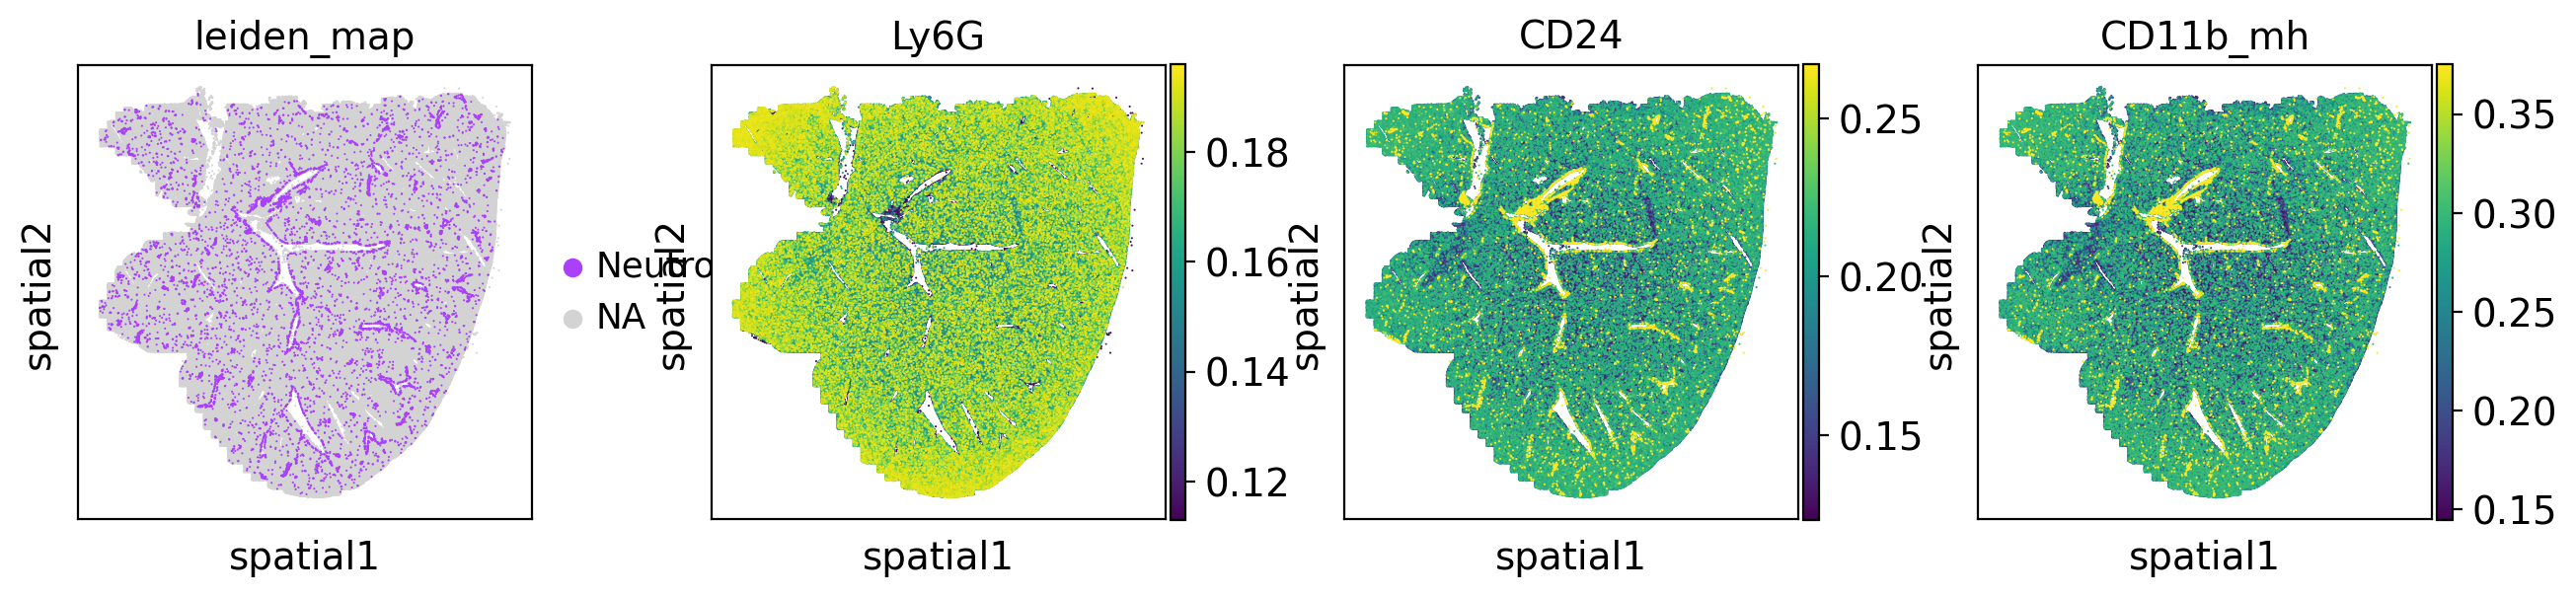

In [59]:
sc.pl.spatial(
    adata_spatial_prot,
    spot_size=0.005,
    color=["leiden_map", "Ly6G", "CD24", "CD11b_mh"],
    groups="Neutrophil",
)

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


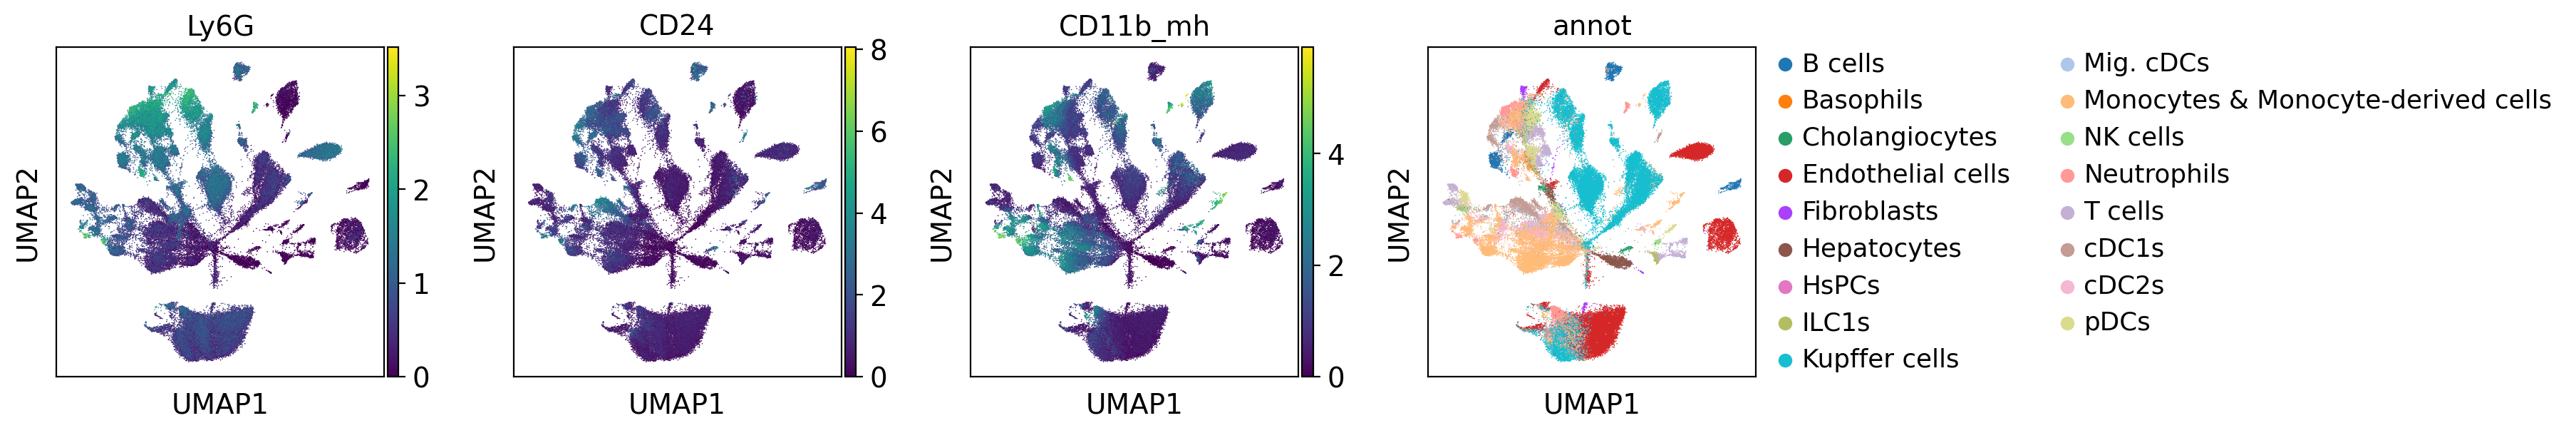

<Figure size 300x300 with 0 Axes>

In [60]:
sc.pl.umap(
    adata_p,
    color=["Ly6G", "CD24", "CD11b_mh", "annot"],
)
plt.tight_layout()

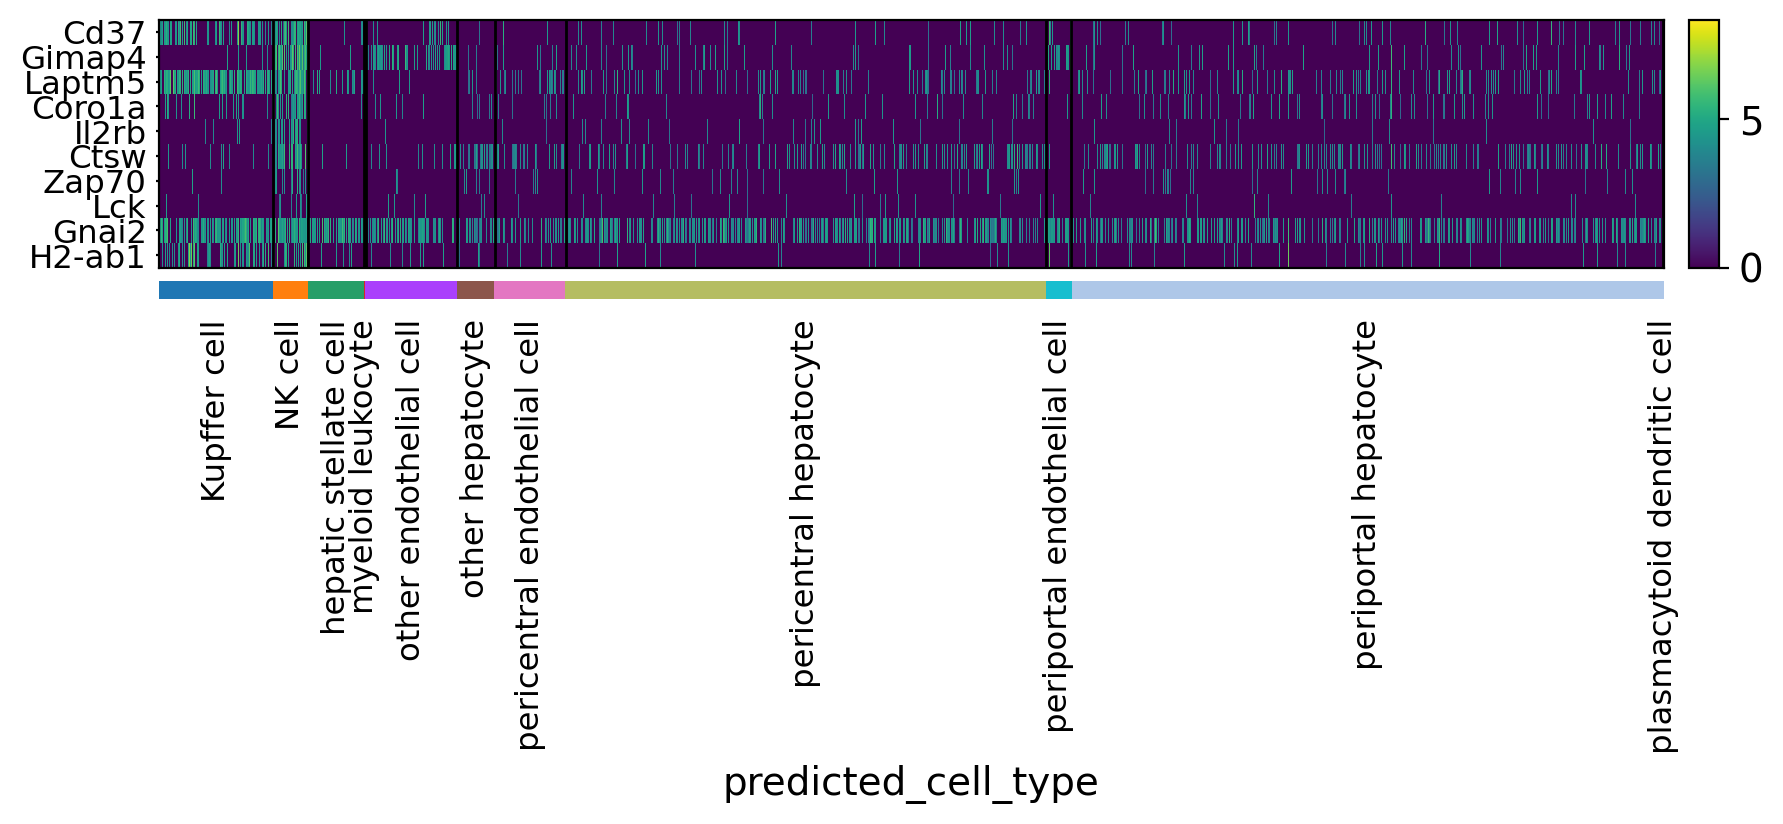

In [46]:
sc.pl.heatmap(
    adata_spatial,
    df_genes.names.values,
    groupby="predicted_cell_type",
    swap_axes=True,
)